In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from keras import models, layers
import tensorflow as tf

In [2]:
df = pd.read_csv("train_tp.csv")
df.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [3]:
df.loc[df["recording_id"] == "3b0e345fc"]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
289,3b0e345fc,9,1,51.8027,843.75,55.3653,5718.75


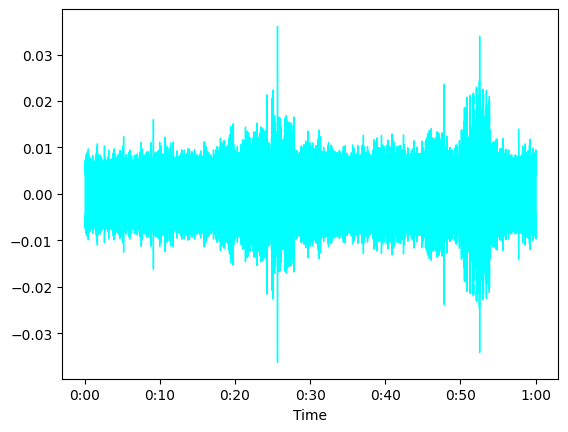

In [4]:
sample_num = 3  # pick a file to display
# get the filename
filename = df.recording_id[sample_num] + str(".flac")
# define the beginning time of the signal
tstart = df.t_min[sample_num]
tend = df.t_max[sample_num]  # define the end time of the signal
y, sr = librosa.load("train/" + str(filename))  # load the file
librosa.display.waveshow(y, sr=sr, x_axis="time", color="cyan")

In [5]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode="constant")

In [6]:
def generate_features(y_cut):
    max_size = 1000  # my max audio file feature width
    stft = padding(
        np.abs(librosa.stft(y_cut, n_fft=255, hop_length=512)), 128, max_size
    )
    MFCCs = padding(
        librosa.feature.mfcc(y_cut, n_fft=255, hop_length=512, n_mfcc=128),
        128,
        max_size,
    )
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    # Now the padding part
    image = np.array([padding(normalize(spec_bw), 1, max_size)]).reshape(1, max_size)
    image = np.append(image, padding(normalize(spec_centroid), 1, max_size), axis=0)
    # repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0, 9):
        image = np.append(image, padding(normalize(spec_bw), 1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid), 1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft), 12, max_size), axis=0)
    image = np.dstack((image, np.abs(stft)))
    image = np.dstack((image, MFCCs))
    return image

In [8]:
img = generate_features(y)

ValueError: cannot reshape array of size 2584 into shape (1,1000)

In [ ]:
X = df.drop("species_id", axis=1)
y = df.species_id

In [ ]:
# Split once to get the test and training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123, stratify=y
)
print(X_train.shape, X_test.shape)

(912, 6) (304, 6)


In [ ]:
# Split twice to get the validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=123
)
print(X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val))

(684, 6) (304, 6) (228, 6) 684 304 228


In [ ]:
def get_features(df_in):
    features = []
    labels = []  # empty array to store labels
    # For each species, determine how many augmentations are needed
    df_in = df_in.reset_index()
    for i in df_in.species_id.unique():
        print("species_id:", i)
        # all the file indices with the same species_id
        filelist = df_in.loc[df_in.species_id == i].index
    for j in range(0, len(filelist)):
        filename = df_in.iloc[filelist[j]].recording_id + str(
            ".flac"
        )  # get the filename
        # define the beginning time of the signal
        tstart = df_in.iloc[filelist[j]].t_min
        tend = df_in.iloc[filelist[j]].t_max  # end of signal
        recording_id = df_in.iloc[filelist[j]].recording_id
        species_id = i
        songtype_id = df_in.iloc[filelist[j]].songtype_id
        # Load the file
        y, sr = librosa.load(f"train/{filename}", sr=28000)
        # cut the file to signal start and end
        y_cut = y[int(round(tstart * sr)) : int(round(tend * sr))]
        # generate features & output numpy array
        data = generate_features(y_cut)
        features.append(data[np.newaxis, ...])
        labels.append(species_id)
    output = np.concatenate(features, axis=0)
    return (np.array(output), labels)


# use get_features to calculate and store the features
test_features, test_labels = get_features(pd.concat([X_test, y_test], axis=1))
train_features, train_labels = get_features(pd.concat([X_train, y_train], axis=1))

species_id: 15
species_id: 17
species_id: 14
species_id: 13
species_id: 22
species_id: 18
species_id: 0
species_id: 6
species_id: 23
species_id: 3
species_id: 4
species_id: 16
species_id: 10
species_id: 19
species_id: 2
species_id: 7
species_id: 5
species_id: 1
species_id: 8
species_id: 20
species_id: 21
species_id: 12
species_id: 11
species_id: 9
species_id: 17
species_id: 11
species_id: 23
species_id: 19
species_id: 4
species_id: 2
species_id: 16
species_id: 9
species_id: 21
species_id: 20
species_id: 22
species_id: 15
species_id: 0
species_id: 14
species_id: 3
species_id: 1
species_id: 6
species_id: 7
species_id: 18
species_id: 5
species_id: 13
species_id: 12
species_id: 10
species_id: 8


In [ ]:
X_train = np.array((X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train)))
X_test = np.array((X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test)))
X_train = X_train / np.std(X_train)
X_test = X_test / np.std(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
input_shape = (128, 1000, 3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation="relu"))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation="relu"))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation="relu"))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation="relu"))
CNNmodel.add(layers.Dense(24, activation="softmax"))

In [ ]:
CNNmodel.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [ ]:
history = CNNmodel.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(test_features, test_labels),
)

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'numpy.int64'>"})

In [ ]:
input_shape = (128, 1000, 3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(32, activation="relu"))
CNNmodel.add(layers.Dense(24, activation="softmax"))
CNNmodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 998, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 499, 32)      0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1005984)           0         
                                                                 
 dense_12 (Dense)            (None, 32)                32191520  
                                                                 
 dense_13 (Dense)            (None, 24)                792       
                                                                 
Total params: 32,193,208
Trainable params: 32,193,208
Non-trainable params: 0
__________________________________________

In [ ]:
# Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict = history.history
loss_values = history_dict["loss"]
acc_values = history_dict["accuracy"]
val_loss_values = history_dict["val_loss"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, 21)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_values, "bo", label="Training Loss")
ax1.plot(epochs, val_loss_values, "orange", label="Validation Loss")
ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(epochs, acc_values, "bo", label="Training accuracy")
ax2.plot(epochs, val_acc_values, "orange", label="Validation accuracy")
ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

NameError: name 'history' is not defined